<a href="https://colab.research.google.com/github/ShreyMhatre/facial_expression_recognition/blob/main/Facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data from Kaggle

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

# The next two commands are to overcome the problem of 2 different paths used by kaggle

Path to dataset files: /kaggle/input/face-expression-recognition-dataset


In [2]:
!cp -r /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1/images/images /content/face_expression_dataset


cp: cannot stat '/root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1/images/images': No such file or directory


In [3]:
!cp -r /kaggle/input/face-expression-recognition-dataset/images/images /content/face_expression_dataset

In [4]:
#rm -rf face_expression_dataset/

In [5]:
ls face_expression_dataset/

train/  validation/


In [6]:
import os

for dirpath, dirnames, filenames in os.walk("face_expression_dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'face_expression_dataset'.
There are 7 directories and 0 images in 'face_expression_dataset/train'.
There are 0 directories and 436 images in 'face_expression_dataset/train/disgust'.
There are 0 directories and 3205 images in 'face_expression_dataset/train/surprise'.
There are 0 directories and 4938 images in 'face_expression_dataset/train/sad'.
There are 0 directories and 7164 images in 'face_expression_dataset/train/happy'.
There are 0 directories and 4982 images in 'face_expression_dataset/train/neutral'.
There are 0 directories and 3993 images in 'face_expression_dataset/train/angry'.
There are 0 directories and 4103 images in 'face_expression_dataset/train/fear'.
There are 7 directories and 0 images in 'face_expression_dataset/validation'.
There are 0 directories and 111 images in 'face_expression_dataset/validation/disgust'.
There are 0 directories and 797 images in 'face_expression_dataset/validation/surprise'.
There are 0 directories and 

# Visualize Sample Data

Setup training and validation directory paths

In [7]:
train_dir = "face_expression_dataset/train"
test_dir = "face_expression_dataset/validation"

Get class names from subdirectories.

In [8]:
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


Visualize an image from the training set.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+"/"+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img


Image shape: (48, 48)


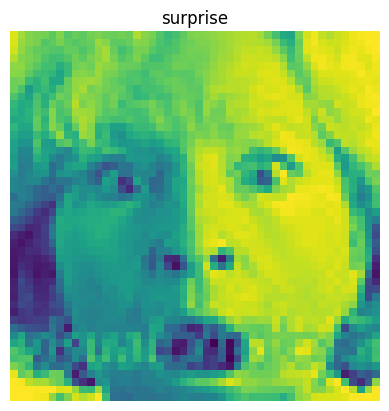

In [10]:
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

Since the dataset in imbalanced, as we see there are only 436 images for disgust compared to 7164 for happy, we'll use augmentation to increase data for disgust. Setting up new paths to handle augmentation...

## Bulding an offline augmentation pipeline for imbalanced class

In [11]:
import os

aug_dir = "face_expression_dataset/train/augmented_disgust"
os.makedirs(aug_dir, exist_ok=True)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import glob

augmentor = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

disgust_images = glob.glob("face_expression_dataset/train/disgust/*.jpg")

# How many augmented images per original?
augment_times = 10

count = 0
for img_path in disgust_images:
    img = load_img(img_path, color_mode="grayscale", target_size=(48, 48))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    # Create 10 new images
    i = 0
    for batch in augmentor.flow(x, batch_size=1,
                                 save_to_dir=aug_dir,
                                 save_prefix='disgust',
                                 save_format='jpg'):
        i += 1
        count += 1
        if i >= augment_times:
            break

print(f"Saved {count} augmented images to {aug_dir}")


Saved 4360 augmented images to face_expression_dataset/train/augmented_disgust


In [13]:
!mv face_expression_dataset/train/augmented_disgust/* \
   face_expression_dataset/train/disgust/


In [14]:
rmdir face_expression_dataset/train/augmented_disgust


In [15]:
import os

for dirpath, dirnames, filenames in os.walk("face_expression_dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'face_expression_dataset'.
There are 7 directories and 0 images in 'face_expression_dataset/train'.
There are 0 directories and 3979 images in 'face_expression_dataset/train/disgust'.
There are 0 directories and 3205 images in 'face_expression_dataset/train/surprise'.
There are 0 directories and 4938 images in 'face_expression_dataset/train/sad'.
There are 0 directories and 7164 images in 'face_expression_dataset/train/happy'.
There are 0 directories and 4982 images in 'face_expression_dataset/train/neutral'.
There are 0 directories and 3993 images in 'face_expression_dataset/train/angry'.
There are 0 directories and 4103 images in 'face_expression_dataset/train/fear'.
There are 7 directories and 0 images in 'face_expression_dataset/validation'.
There are 0 directories and 111 images in 'face_expression_dataset/validation/disgust'.
There are 0 directories and 797 images in 'face_expression_dataset/validation/surprise'.
There are 0 directories and

Offline augmentation successful...

# Preprocessing data

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(48, 48),
                                               color_mode='grayscale',
                                               batch_size=64,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=(48, 48),
                                              color_mode='grayscale',
                                              batch_size=64,
                                              class_mode='categorical')

Found 32364 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Calculating class_weight

In [17]:
import os

class_names = sorted(os.listdir(train_dir))
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}
print("Samples per class:", class_counts)


Samples per class: {'angry': 3993, 'disgust': 3979, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}


In [18]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train_labels = []
class_indices = {cls: i for i, cls in enumerate(class_names)}

for cls in class_names:
    y_train_labels += [class_indices[cls]] * class_counts[cls]

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)


Class weights: {0: np.float64(1.1578834388751744), 1: np.float64(1.1619574193085125), 2: np.float64(1.1268409874307999), 3: np.float64(0.6453697056712132), 4: np.float64(0.9280266100820095), 5: np.float64(0.9362957819822948), 6: np.float64(1.4425674169823937)}


# Loss curve

In [19]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# Building Model


## Model 1:- No class_weights

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model_1 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(48, 48, 1)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(7, activation='softmax'),
])

model_1.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
    )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2438 - loss: 1.8672

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


506/506 ━━━━━━━━━━━━━━━━━━━━ 86s 165ms/step - accuracy: 0.2439 - loss: 1.8670 - val_accuracy: 0.3358 - val_loss: 1.7340
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 85s 168ms/step - accuracy: 0.3837 - loss: 1.6396 - val_accuracy: 0.4019 - val_loss: 1.5874
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.4220 - loss: 1.5545 - val_accuracy: 0.4107 - val_loss: 1.5637
Epoch 4/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - accuracy: 0.4529 - loss: 1.4792 - val_accuracy: 0.4414 - val_loss: 1.4974
Epoch 5/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.4815 - loss: 1.3994 - val_accuracy: 0.4498 - val_loss: 1.4706
Epoch 6/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 84s 166ms/step - accuracy: 0.5040 - loss: 1.3567 - val_accuracy: 0.4421 - val_loss: 1.5080
Epoch 7/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.5051 - loss: 1.3278 - val_accuracy: 0.4352 - val_loss: 1.5036
Epoch 8/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.5206 - loss: 1.2967 - val

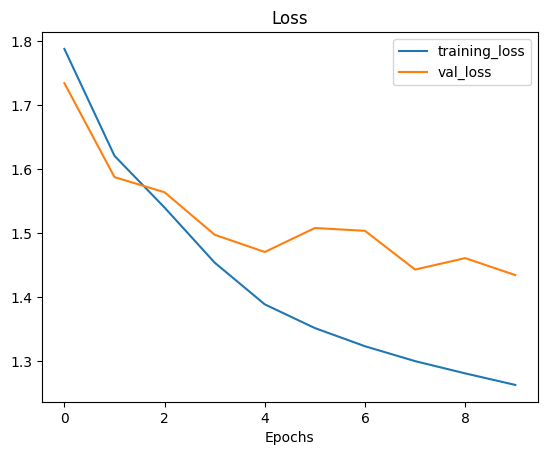

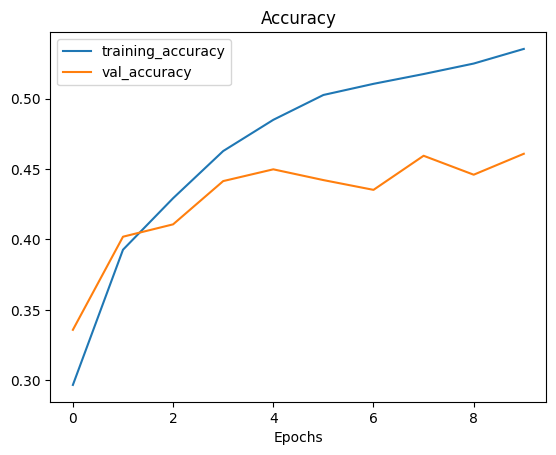

In [21]:
plot_loss_curves(history_1)

In [22]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 10)     │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 810)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │         5,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,523 (99.70 KB)

 Trainable params: 8,507 (33.23 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,016 (66.47 KB)

## Model 2: With class_weights

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

model_2 = Sequential([
    Conv2D(10, 3, activation='relu', input_shape=(48, 48, 1)),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Conv2D(10, 3, activation='relu'),
    Conv2D(10, 3, activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(7, activation='softmax'),
])

model_2.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    class_weight=class_weights
    )

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


506/506 ━━━━━━━━━━━━━━━━━━━━ 84s 161ms/step - accuracy: 0.2250 - loss: 1.8539 - val_accuracy: 0.3480 - val_loss: 1.7030
Epoch 2/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.3875 - loss: 1.6209 - val_accuracy: 0.3900 - val_loss: 1.6010
Epoch 3/10
506/506 ━━━━━━━━━━━━━━━━━━━━ 80s 159ms/step - accuracy: 0.4302 - loss: 1.5129 - val_accuracy: 0.4295 - val_loss: 1.5094
Epoch 4/10
261/506 ━━━━━━━━━━━━━━━━━━━━ 36s 151ms/step - accuracy: 0.4716 - loss: 1.4286

In [ ]:
plot_loss_curves(history_2)

In [ ]:
model_2.summary()

## Model 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten, Dense

model_3 = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(64, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

model_3.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)


In [ ]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss',patience=2,restore_best_weights=True, verbose=1),
    #ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2,verbose=1,min_delta=0.0001)
]

checkpoint = ModelCheckpoint("./model.h5", monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

history_3 = model_3.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    class_weight=class_weights,
    callbacks=callbacks
    )

In [ ]:
plot_loss_curves(history_3)

In [ ]:
model_3.evaluate(test_data)